In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import mmcv
import matplotlib.pyplot as plt
import data

In [3]:
d = data.read_cvat_anno('/media/tormod/Den Lille/Thesis/annotations/IMG_2139.xml')

In [5]:
vid = mmcv.VideoReader('videos/IMG_2139.MOV')

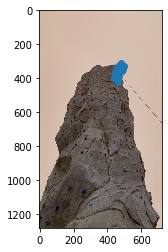